<a href="https://colab.research.google.com/github/Mr-Kondo/Open/blob/main/Anomaly_Sound_Detection_AE_WAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [機械稼働音の異常検知](https://signate.jp/competitions/358)

## Refference

1 [音声ファイル前処理（データロード）)](https://work-in-progress.hatenablog.com/entry/2020/02/16/112452)  
2 [「ToyADMOS:異常音検知」：AutoEncoder](https://note.com/toshi_sugi/n/nc4a5b9c4d6cf)  
3 [Dectecting Anomaly using Autoencoder!](https://www.kaggle.com/code/ohseokkim/dectecting-anomaly-using-autoencoder)  
4 [stack overflow, how to set rmse cost function in tensorflow](https://stackoverflow.com/questions/33846069/how-to-set-rmse-cost-function-in-tensorflow)  
5 [回帰分析における評価指標　―①RMSE/MSE―](https://www.scsk.jp/sp/mwai/blog/cat/rmsemse.html)  
6 [損失関数とは](https://www.ibm.com/jp-ja/think/topics/loss-function)  
7 [Kaggle, Dectecting Anomaly using Autoencoder!](https://www.kaggle.com/code/ohseokkim/dectecting-anomaly-using-autoencoder)

## Import modules

In [2]:
import os
import gc
import pathlib
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from keras import Model, layers, optimizers, callbacks

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report

from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Define Functions

In [3]:
# データセットの生のWAVオーディオファイルをオーディオテンソルに前処理する関数を定義
# normalized to the [-1.0, 1.0] range
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1) # モノラル信号のため、チャンネル軸を除去

# すべてをまとめる別のヘルパー関数get_waveformを定義
# 入力はWAVオーディオファイル名です。
# 出力は、教師あり学習の準備ができているオーディオテンソルを含むタプルです。
def get_waveform(file_path):
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform

# 波形をフーリエ変換
# 周波数はlog10スケールに変換
def get_fft(waveform):
  waveform = tf.complex(waveform, 0.0)
  fft = tf.signal.fft(waveform)
  fft = tf.abs(fft)
  # Convert the frequencies to log scale and transpose
  fft_log_spec = tf.experimental.numpy.log10((fft + 2.2204460492503131e-16) / 2.2204460492503131e-16)
  fft_log_spec = fft_log_spec[0:len(fft)//2]
  return fft_log_spec

# AudioファイルをFFTへ変換
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform,
      num_parallel_calls= tf.data.AUTOTUNE
      )
  output_ds = output_ds.map(
      map_func=get_fft,
      num_parallel_calls=tf.data.AUTOTUNE
      )#.batch(len(files))
  return output_ds

# RSMEを計算
def rmse(true, pred):
  return tf.sqrt(tf.reduce_mean((true - pred)**2))

def train_loss(model, true_ds):
  pred_ds = model(true_ds)
  loss = rmse(true_ds, pred_ds)
  return tf.cast(loss, tf.float32)  

# しきい値が再構成エラーよりも大きい場合は、オーディオファイル を異常として分類します。
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less_equal(loss, threshold)

# しきい値が再構成エラーよりも大きい場合は、オーディオファイル を異常として分類します。
def predict_rmse(model, data, threshold):
  reconstructions = model(data)
  loss = tf.sqrt(tf.reduce_mean((data - reconstructions)**2, 1))
  return tf.math.greater(loss, threshold)

## Define Auto Encoder Class

In [4]:
class Autoencoder(Model):
  def __init__(self, shape):
    super(Autoencoder, self).__init__()
    self.shape = shape
    
    self.encoder = keras.Sequential([
      layers.Dense(32, activation='relu'),
      layers.Dense(16, activation='relu'),
      layers.Dense(8, activation='relu')
    ])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(shape, activation="sigmoid"),
    ])
  
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

## Read Audio(.wav) Data

### Train Notmal

In [6]:
# オーディオクリップをfilenamesというリストに抽出します
filenames = glob.glob('../01_input/wav/train_normal/dummy/*.wav')
num_samples = len(filenames)
filenames.sort()
print('Number of total examples:', num_samples)
print('Example file tensor:', filenames[0])

Number of total examples: 300
Example file tensor: ../01_input/wav/train_normal/dummy\000.wav


In [7]:
# オーディオファイルの形状を確認
train_file = tf.io.read_file(filenames[0])
train_audio, sampling_rate = tf.audio.decode_wav(contents=train_file)
# tf.audio.decode_wavによって返されるテンソルの形状は[samples, channels]
# channelsはモノラルの場合は1 、ステレオの場合は2
train_audio.shape

TensorShape([160000, 1])

In [8]:
# Audio Setting
Data_num = train_audio.shape[0]
Sampling_freq = sampling_rate.numpy()
time_length = Data_num / Sampling_freq

print("Data数：", Data_num)
print("サンプリング周波数[Hz]：", Sampling_freq)
print("時間窓長[sec]:", time_length)
print("分析周波数レンジ[Hz]:", Sampling_freq / 2)

Data数： 160000
サンプリング周波数[Hz]： 16000
時間窓長[sec]: 10.0
分析周波数レンジ[Hz]: 8000.0


In [9]:
AUTOTUNE = tf.data.AUTOTUNE

# 前に定義したget_waveform使用して、
# Dataset.from_tensor_slicesとDataset.mapを使用してtf.data.Datasetを作成します。

files_ds = tf.data.Dataset.from_tensor_slices(filenames)

waveform_ds = files_ds.map(
    map_func=get_waveform,
    num_parallel_calls=AUTOTUNE) # トレーニングセット作成

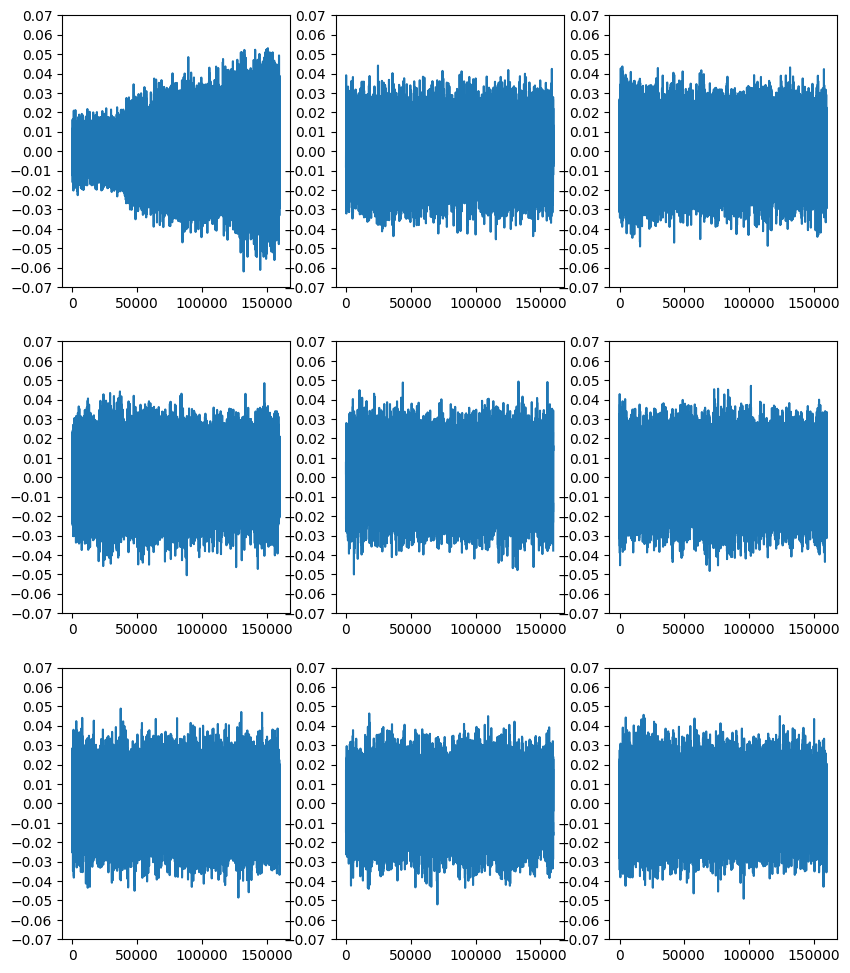

In [10]:
# いくつかのオーディオ波形をプロット

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, audio in enumerate(waveform_ds.take(n)):

  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-0.07, 0.07, 0.01))

plt.show()

In [11]:
for waveform in waveform_ds.take(1):
  #label = label.numpy().decode('utf-8')
  # spectrogram = get_spectrogram(waveform)
  fft = get_fft(waveform)

#print('Label:', label)
print('Waveform shape:', waveform.shape)
#print('Spectrogram shape:', spectrogram.shape)
print('FFT shape:', fft.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=Sampling_freq))

Waveform shape: (160000,)
FFT shape: (80000,)
Audio playback


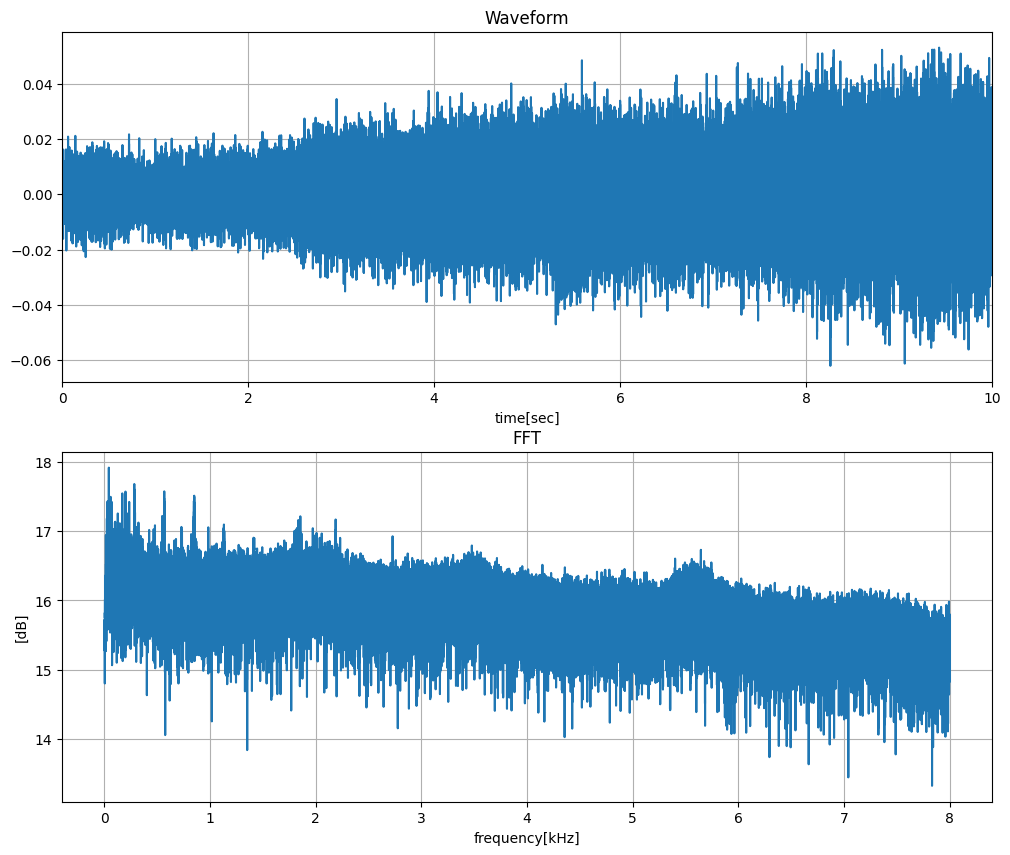

In [12]:
# 時間波形と周波数波形をプロット
timescale = np.arange(Data_num) #len(waveform)
timescale = timescale/Sampling_freq

freq = np.arange(Data_num//2) * Sampling_freq / Data_num

fig, axes = plt.subplots(2, figsize=(12, 10))

axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, Data_num/Sampling_freq]) # [0, Data_num]
axes[0].set_xlabel("time[sec]")
axes[0].grid()

axes[1].plot(freq/1000, fft)
axes[1].set_title('FFT')
axes[1].set_xlabel("frequency[kHz]")
axes[1].set_ylabel("[dB]")
axes[1].grid()
plt.show()

In [13]:
# 各データリストをFFTへ変換
del files_ds
gc.collect()

train_ds = preprocess_dataset(filenames)
train_ds = list(train_ds)

In [14]:
# FFTの値を[0,1]の範囲へnormarization
min_val = tf.reduce_min(train_ds) # trainデータセットの最小値取得
max_val = tf.reduce_max(train_ds) # trainデータセットの最大値取得

train_ds = (train_ds - min_val) / (max_val - min_val) # [0,1]へ正規化
train_ds = tf.cast(train_ds, tf.float32) # 型の変換

In [15]:
input_shape = train_ds.shape
input_shape = input_shape[1]
print('Input shape:', input_shape)

Input shape: 80000


In [16]:
autoencoder = Autoencoder(input_shape)
adam_low_rate = optimizers.Adam(learning_rate=1e-4)
autoencoder.compile(optimizer=adam_low_rate, loss=rmse)

In [17]:
%%time

# オートエンコーダは正常の オーディオファイル のみを使用してトレーニング、
# 完全なテストセットを使用して評価されることに注意。
import datetime

time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

#Training the model
es_callback = callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=5)
'''
ckpt_filepath = '../04_model/ckpt'+time+'/checkpoint-{epoch:03d}-{loss:.4f}.keras'
cp_callback = callbacks.ModelCheckpoint(filepath = ckpt_filepath, 
                                        monitor = 'loss',
                                        save_freq="epoch",
                                        save_best_only = True)
'''
EPOCHS = 600
history = autoencoder.fit(
                        train_ds, train_ds,
                        epochs=EPOCHS,
                        batch_size= 512,
                        #validation_data=(train_ds, train_ds),
                        shuffle=True,
                        #callbacks=[es_callback, cp_callback]
                        callbacks=[es_callback]
                        )

Epoch 1/600
1/1 [==============================] - 5s 5s/step - loss: 0.0974
Epoch 2/600
1/1 [==============================] - 0s 398ms/step - loss: 0.0974
Epoch 3/600
1/1 [==============================] - 0s 366ms/step - loss: 0.0974
Epoch 4/600
1/1 [==============================] - 0s 327ms/step - loss: 0.0973
Epoch 5/600
1/1 [==============================] - 0s 210ms/step - loss: 0.0973
Epoch 6/600
1/1 [==============================] - 0s 210ms/step - loss: 0.0973
Epoch 7/600
1/1 [==============================] - 0s 213ms/step - loss: 0.0972
Epoch 8/600
1/1 [==============================] - 0s 199ms/step - loss: 0.0971
Epoch 9/600
1/1 [==============================] - 0s 184ms/step - loss: 0.0970
Epoch 10/600
1/1 [==============================] - 0s 194ms/step - loss: 0.0968
Epoch 11/600
1/1 [==============================] - 0s 189ms/step - loss: 0.0965
Epoch 12/600
1/1 [==============================] - 0s 207ms/step - loss: 0.0961
Epoch 13/600
1/1 [======================

In [18]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 8)                 2560696   
                                                                 
 sequential_1 (Sequential)   (None, 80000)             2640688   
                                                                 
Total params: 5,201,384
Trainable params: 5,201,384
Non-trainable params: 0
_________________________________________________________________


In [21]:
autoencoder.save( '../04_model/autoencoder_wav_'+datetime.datetime.now().strftime("%Y%m%d-%H%M%S"+".H5"), save_format='tf')

INFO:tensorflow:Assets written to: ../04_model/autoencoder_wav_20241223-094723.H5\assets


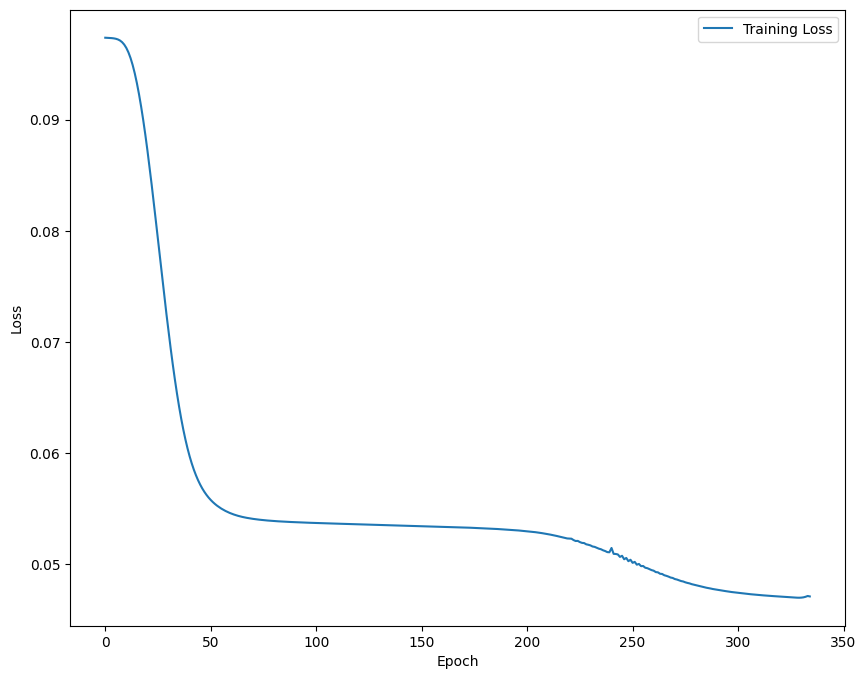

In [22]:
fig = plt.figure(figsize=(10, 8))

plt.plot(history.history["loss"], label="Training Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

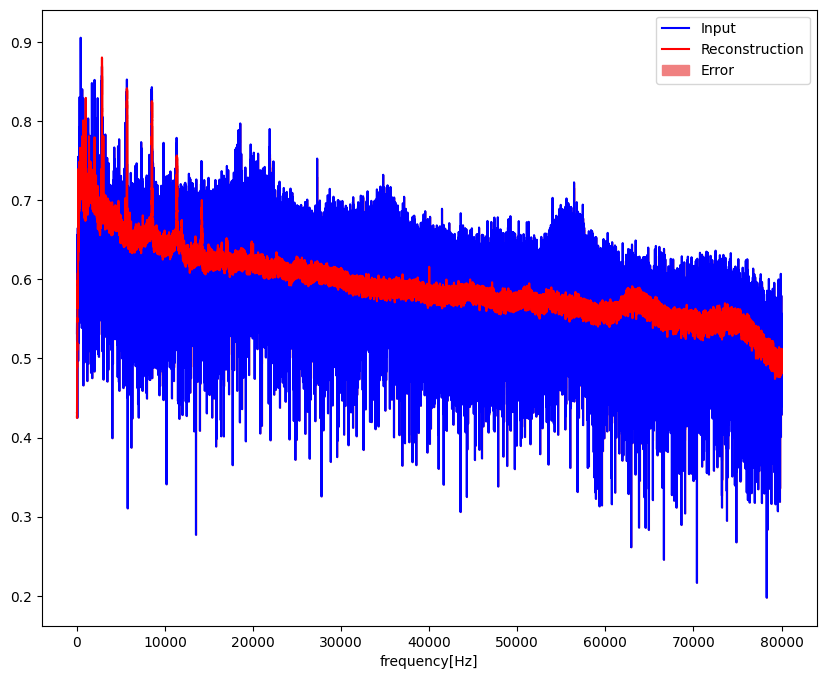

In [23]:
# 正常なテストサンプル

decoded_data = autoencoder(train_ds).numpy()

fig = plt.figure(figsize=(10, 8))

plt.plot(train_ds[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(input_shape), decoded_data[0], train_ds[0], color='lightcoral') #
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.xlabel('frequency[Hz]')
plt.show()

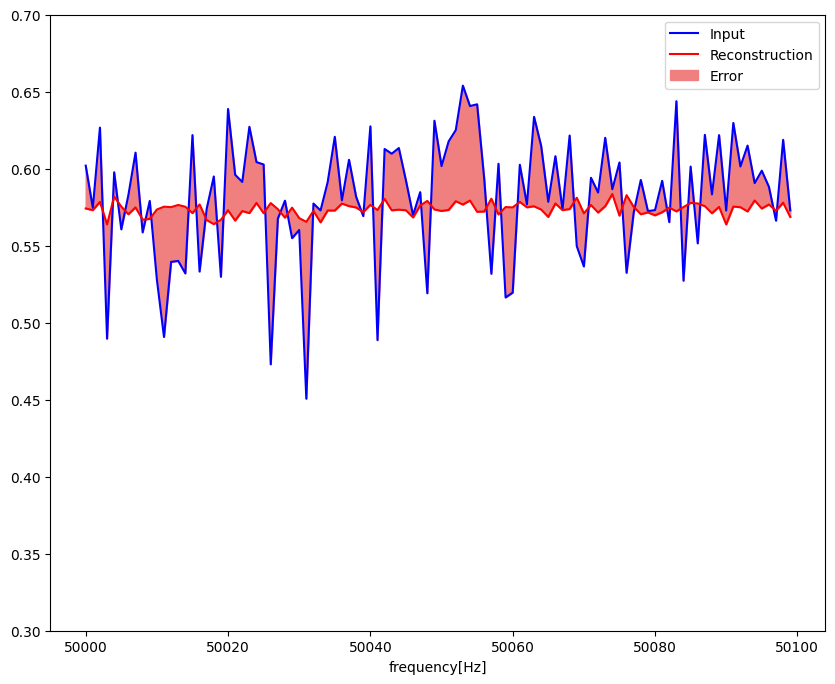

In [24]:
# 拡大
start = 50000
length = 100
end = start + length

fig = plt.figure(figsize=(10, 8))

plt.plot(np.arange(start,end), train_ds[0][start:end], 'b')
plt.plot(np.arange(start,end), decoded_data[0][start:end], 'r')
plt.fill_between(np.arange(start,end), decoded_data[0][start:end], train_ds[0][start:end], color='lightcoral') # 
plt.ylim([0.3, 0.7])
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.xlabel('frequency[Hz]')
plt.show()

### Valid Notmal

In [26]:
# オーディオクリップをfilenamesというリストに抽出します
filenames = glob.glob('../01_input/wav/valid_normal/dummy/*.wav')
num_samples = len(filenames)
filenames.sort()
print('Number of total examples:', num_samples)
print('Example file tensor:', filenames[0])

Number of total examples: 150
Example file tensor: ../01_input/wav/valid_normal/dummy\000.wav


In [27]:
# オーディオファイルの形状を確認
valid_normal_file = tf.io.read_file(filenames[0])
valid_normal_audio, valid_normal_sampling_rate = tf.audio.decode_wav(contents=valid_normal_file)
# tf.audio.decode_wavによって返されるテンソルの形状は[samples, channels]
# channelsはモノラルの場合は1 、ステレオの場合は2
valid_normal_audio.shape

TensorShape([160000, 1])

In [28]:
# Audio Setting
Data_num = valid_normal_audio.shape[0]
Sampling_freq = valid_normal_sampling_rate.numpy()
time_length = Data_num / Sampling_freq

print("Data数：", Data_num)
print("サンプリング周波数[Hz]：", Sampling_freq)
print("時間窓長[sec]:", time_length)
print("分析周波数レンジ[Hz]:", Sampling_freq / 2)

Data数： 160000
サンプリング周波数[Hz]： 16000
時間窓長[sec]: 10.0
分析周波数レンジ[Hz]: 8000.0


In [29]:
AUTOTUNE = tf.data.AUTOTUNE
valid_normal_ds = tf.data.Dataset.from_tensor_slices(filenames)

waveform_ds = valid_normal_ds.map(
    map_func=get_waveform,
    num_parallel_calls=AUTOTUNE) # トレーニングセット作成

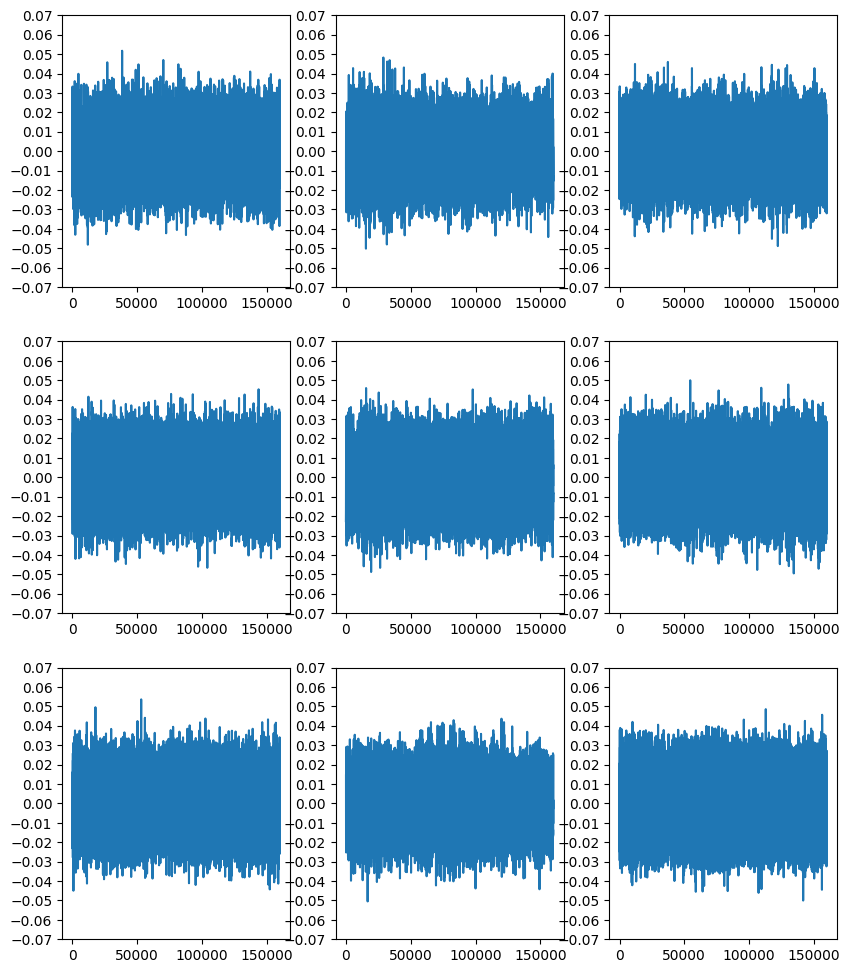

In [30]:
# いくつかのオーディオ波形をプロット

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, audio in enumerate(waveform_ds.take(n)):

  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-0.07, 0.07, 0.01))

plt.show()

In [31]:
for waveform in waveform_ds.take(1):
  #label = label.numpy().decode('utf-8')
  # spectrogram = get_spectrogram(waveform)
  fft = get_fft(waveform)

#print('Label:', label)
print('Waveform shape:', waveform.shape)
#print('Spectrogram shape:', spectrogram.shape)
print('FFT shape:', fft.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=Sampling_freq))

Waveform shape: (160000,)
FFT shape: (80000,)
Audio playback


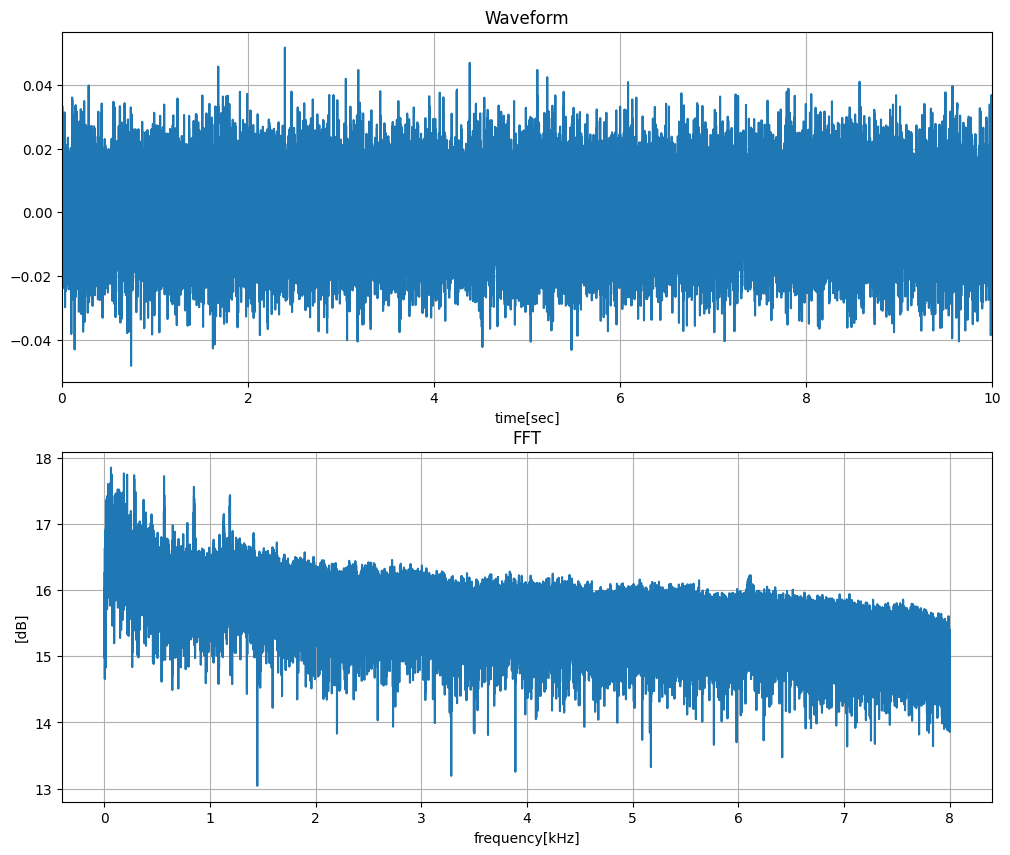

In [32]:
# 時間波形と周波数波形をプロット
timescale = np.arange(Data_num) #len(waveform)
timescale = timescale/Sampling_freq

freq = np.arange(Data_num//2) * Sampling_freq / Data_num

fig, axes = plt.subplots(2, figsize=(12, 10))

axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, Data_num/Sampling_freq]) # [0, Data_num]
axes[0].set_xlabel("time[sec]")
axes[0].grid()

axes[1].plot(freq/1000, fft)
axes[1].set_title('FFT')
axes[1].set_xlabel("frequency[kHz]")
axes[1].set_ylabel("[dB]")
axes[1].grid()
plt.show()

In [33]:
# 各データリストをFFTへ変換
valid_normal_ds = preprocess_dataset(filenames)
valid_normal_ds = list(valid_normal_ds)

In [34]:
# FFTの値を[0,1]の範囲へnormarization
min_val = tf.reduce_min(valid_normal_ds) # trainデータセットの最小値取得
max_val = tf.reduce_max(valid_normal_ds) # trainデータセットの最大値取得

valid_normal_ds = (valid_normal_ds - min_val) / (max_val - min_val) # [0,1]へ正規化
valid_normal_ds = tf.cast(valid_normal_ds, tf.float32) # 型の変換

In [35]:
input_shape = valid_normal_ds.shape
input_shape = input_shape[1]
print('Input shape:', input_shape)

Input shape: 80000


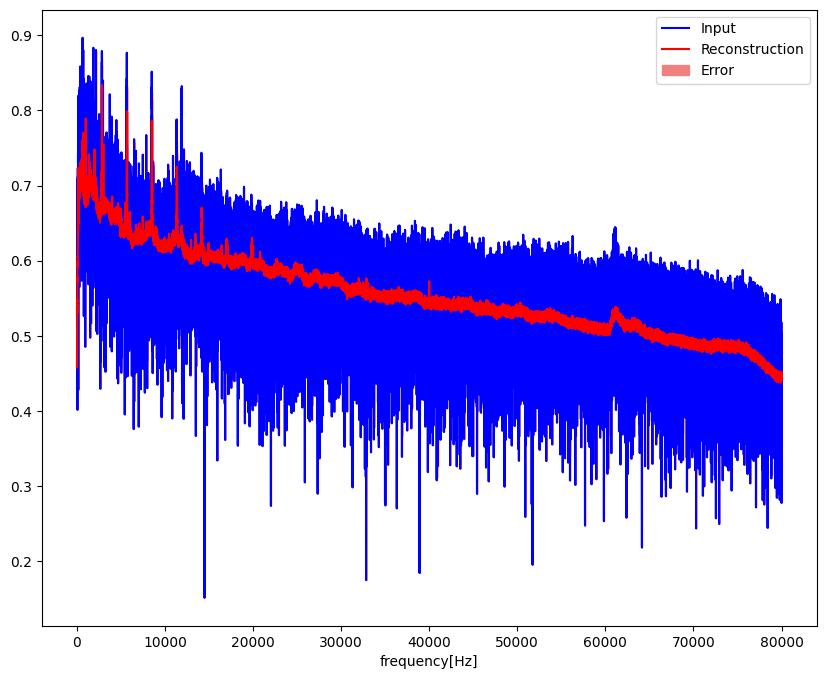

In [36]:
# 正常な検証サンプル

decoded_data = autoencoder(valid_normal_ds).numpy()

fig = plt.figure(figsize=(10, 8))

plt.plot(valid_normal_ds[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(input_shape), decoded_data[0], valid_normal_ds[0], color='lightcoral') #
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.xlabel('frequency[Hz]')
plt.show()

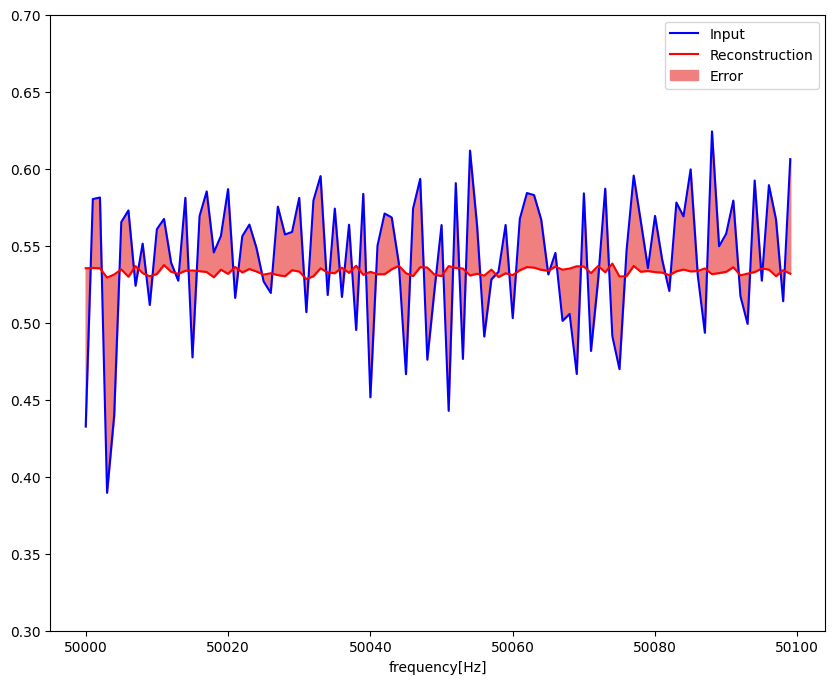

In [37]:
# 拡大
start = 50000
length = 100
end = start + length

fig = plt.figure(figsize=(10, 8))

plt.plot(np.arange(start,end), valid_normal_ds[0][start:end], 'b')
plt.plot(np.arange(start,end), decoded_data[0][start:end], 'r')
plt.fill_between(np.arange(start,end), decoded_data[0][start:end], valid_normal_ds[0][start:end], color='lightcoral') # 
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.ylim([0.3, 0.7])
plt.xlabel('frequency[Hz]')
plt.show()

5/5 [==============================] - 0s 7ms/step


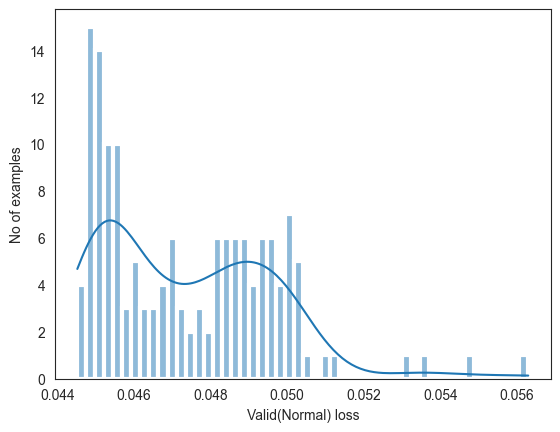

In [90]:
reconstructions = tf.cast(autoencoder.predict(valid_normal_ds), tf.float32)
train_loss = tf.sqrt(tf.reduce_mean((valid_normal_ds - reconstructions)**2, 1))
sns.set_style("white")
sns.histplot(train_loss, bins=50, kde=True, linewidth=3)
plt.xlabel("Valid(Normal) loss")
plt.ylabel("No of examples")
plt.show()

In [91]:
# 平均＋標準偏差をしきい値とします。
threshold_nor = np.mean(train_loss) + np.std(train_loss)
print("Mean: ", np.mean(train_loss))
print("Std: ", np.std(train_loss))
print("Threshold: ", threshold_nor)

Mean:  0.047397926
Std:  0.0022382424
Threshold:  0.04963617


### Valid_Anomaly

In [40]:
# オーディオクリップをfilenamesというリストに抽出します
filenames = glob.glob('../01_input/wav/valid_anomaly/dummy/*.wav')
num_samples = len(filenames)
filenames.sort()
print('Number of total examples:', num_samples)
print('Example file tensor:', filenames[0])

Number of total examples: 50
Example file tensor: ../01_input/wav/valid_anomaly/dummy\000.wav


In [41]:
# オーディオファイルの形状を確認
valid_anomaly_file = tf.io.read_file(filenames[0])
valid_anomaly_audio, valid_anomaly_sampling_rate = tf.audio.decode_wav(contents=valid_anomaly_file)
# tf.audio.decode_wavによって返されるテンソルの形状は[samples, channels]
# channelsはモノラルの場合は1 、ステレオの場合は2
valid_anomaly_audio.shape

TensorShape([160000, 1])

In [42]:
# Audio Setting
Data_num = valid_anomaly_audio.shape[0]
Sampling_freq = valid_anomaly_sampling_rate.numpy()
time_length = Data_num / Sampling_freq

print("Data数：", Data_num)
print("サンプリング周波数[Hz]：", Sampling_freq)
print("時間窓長[sec]:", time_length)
print("分析周波数レンジ[Hz]:", Sampling_freq / 2)

Data数： 160000
サンプリング周波数[Hz]： 16000
時間窓長[sec]: 10.0
分析周波数レンジ[Hz]: 8000.0


In [43]:
AUTOTUNE = tf.data.AUTOTUNE
valid_anomaly_ds = tf.data.Dataset.from_tensor_slices(filenames)

waveform_ds = valid_anomaly_ds.map(
    map_func=get_waveform,
    num_parallel_calls=AUTOTUNE) # トレーニングセット作成

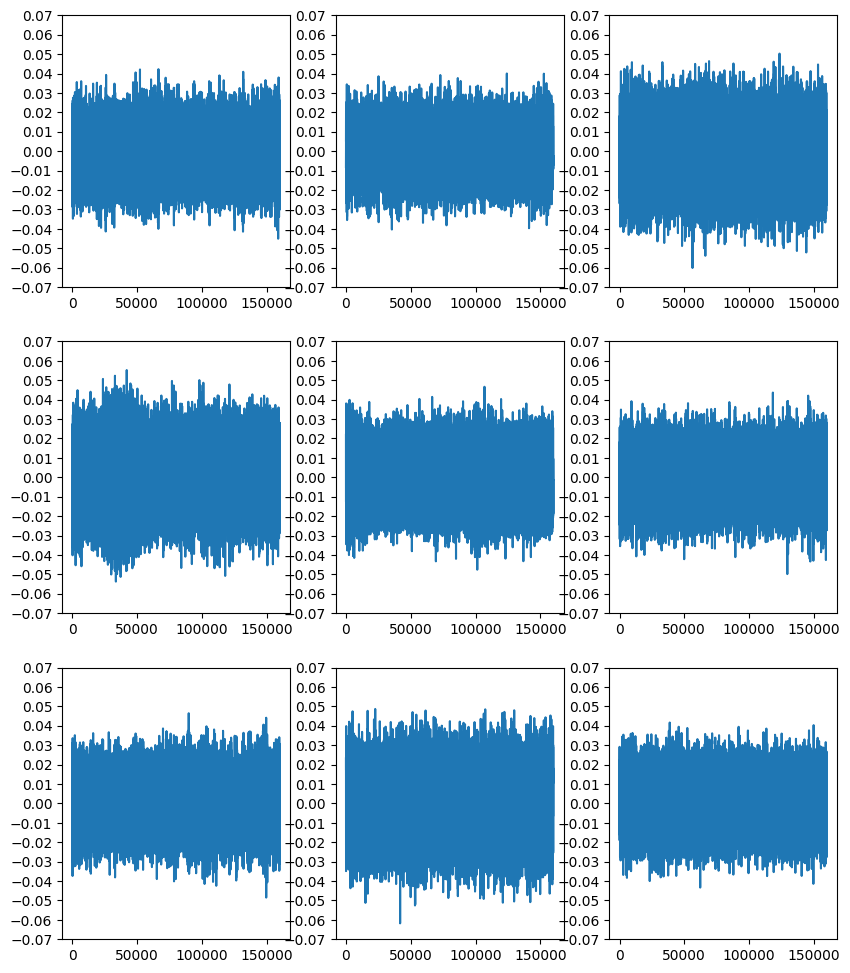

In [44]:
# いくつかのオーディオ波形をプロット

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, audio in enumerate(waveform_ds.take(n)):

  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-0.07, 0.07, 0.01))

plt.show()

In [45]:
for waveform in waveform_ds.take(1):
  #label = label.numpy().decode('utf-8')
  # spectrogram = get_spectrogram(waveform)
  fft = get_fft(waveform)

#print('Label:', label)
print('Waveform shape:', waveform.shape)
#print('Spectrogram shape:', spectrogram.shape)
print('FFT shape:', fft.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=Sampling_freq))

Waveform shape: (160000,)
FFT shape: (80000,)
Audio playback


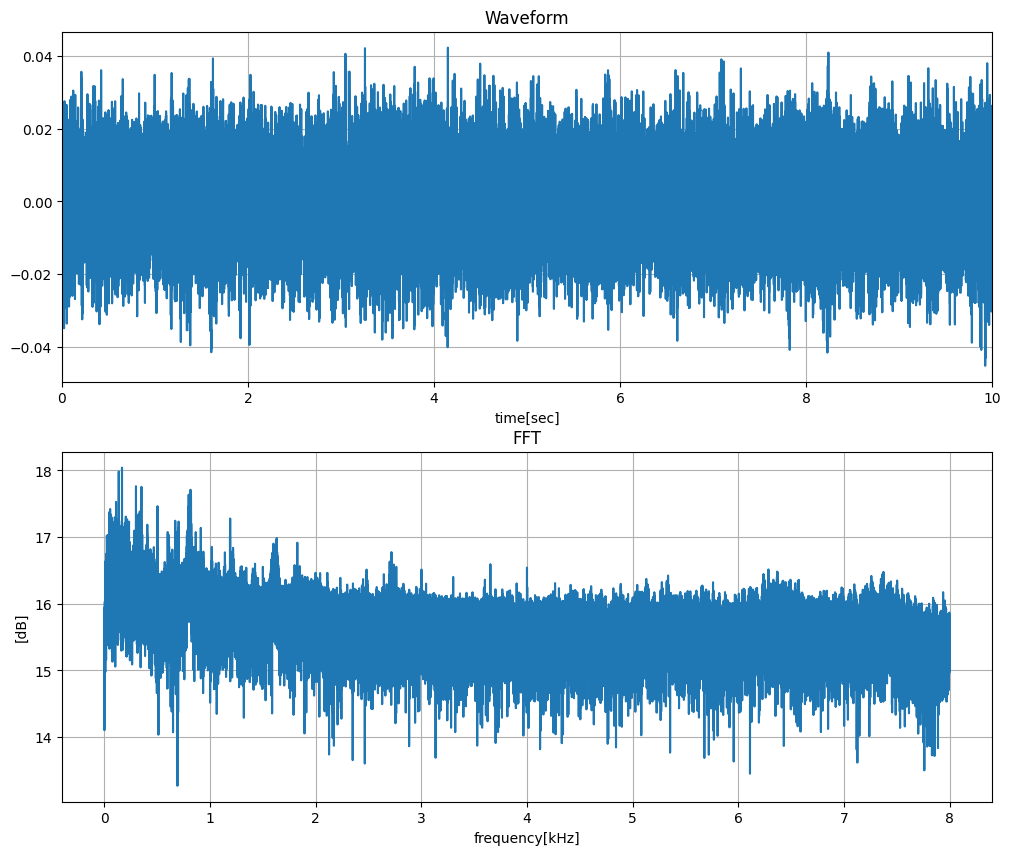

In [46]:
# 時間波形と周波数波形をプロット
timescale = np.arange(Data_num) #len(waveform)
timescale = timescale/Sampling_freq

freq = np.arange(Data_num//2) * Sampling_freq / Data_num

fig, axes = plt.subplots(2, figsize=(12, 10))

axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, Data_num/Sampling_freq]) # [0, Data_num]
axes[0].set_xlabel("time[sec]")
axes[0].grid()

axes[1].plot(freq/1000, fft)
axes[1].set_title('FFT')
axes[1].set_xlabel("frequency[kHz]")
axes[1].set_ylabel("[dB]")
axes[1].grid()
plt.show()

In [47]:
# 各データリストをFFTへ変換
valid_anomaly_ds = preprocess_dataset(filenames)
valid_anomaly_ds = list(valid_anomaly_ds)

In [48]:
# FFTの値を[0,1]の範囲へnormarization
min_val = tf.reduce_min(valid_anomaly_ds) # trainデータセットの最小値取得
max_val = tf.reduce_max(valid_anomaly_ds) # trainデータセットの最大値取得

valid_anomaly_ds = (valid_anomaly_ds - min_val) / (max_val - min_val) # [0,1]へ正規化
valid_anomaly_ds = tf.cast(valid_anomaly_ds, tf.float32) # 型の変換

In [49]:
input_shape = valid_anomaly_ds.shape
input_shape = input_shape[1]
print('Input shape:', input_shape)

Input shape: 80000


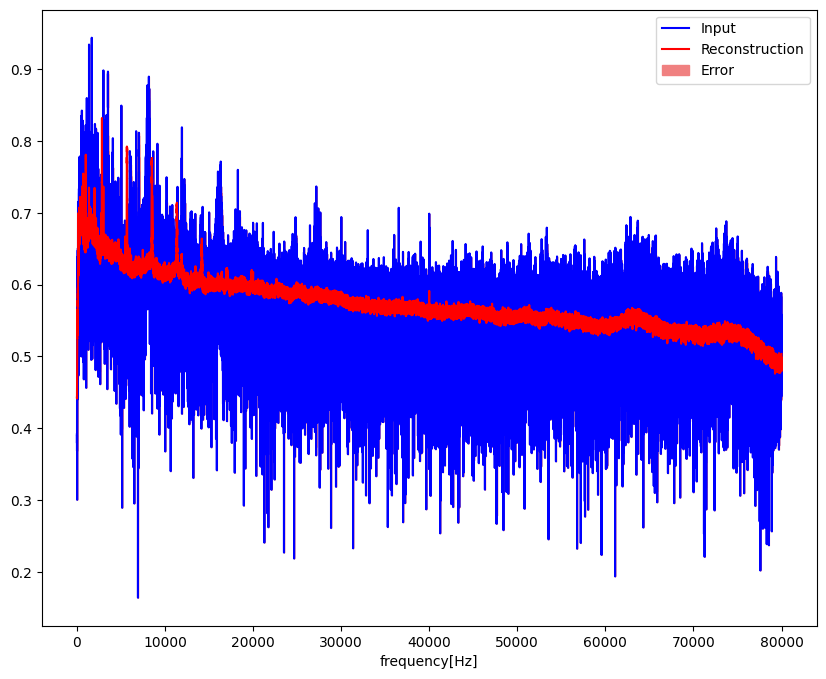

In [50]:
# 異常な検証サンプル

decoded_data = autoencoder(valid_anomaly_ds).numpy()

fig = plt.figure(figsize=(10, 8))

plt.plot(valid_anomaly_ds[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(input_shape), decoded_data[0], valid_anomaly_ds[0], color='lightcoral') #
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.xlabel('frequency[Hz]')
plt.show()

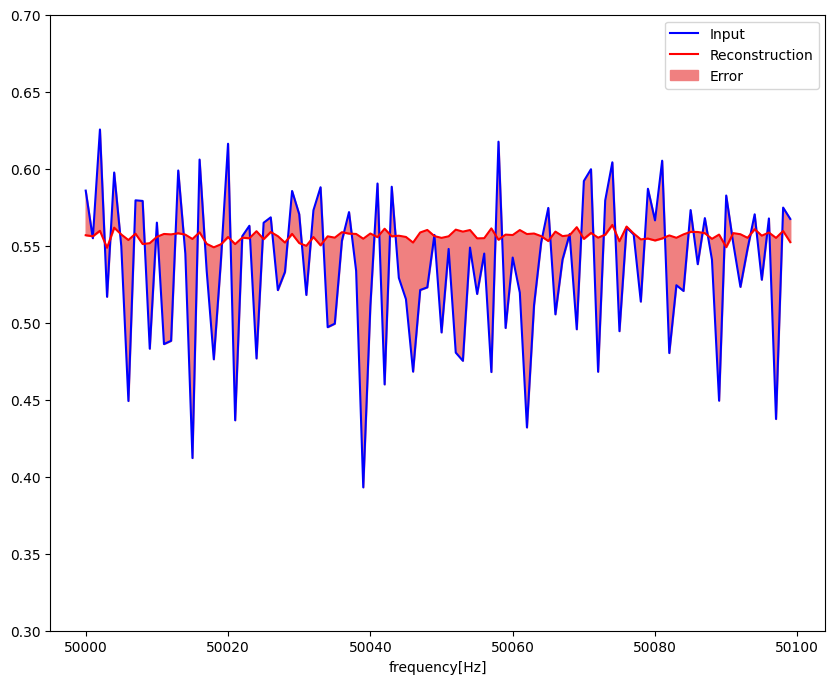

In [51]:
# 拡大
start = 50000
length = 100
end = start + length

fig = plt.figure(figsize=(10, 8))

plt.plot(np.arange(start,end), valid_anomaly_ds[0][start:end], 'b')
plt.plot(np.arange(start,end), decoded_data[0][start:end], 'r')
plt.fill_between(np.arange(start,end), decoded_data[0][start:end], valid_anomaly_ds[0][start:end], color='lightcoral') # 
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.ylim([0.3, 0.7])
plt.xlabel('frequency[Hz]')
plt.show()

2/2 [==============================] - 0s 9ms/step


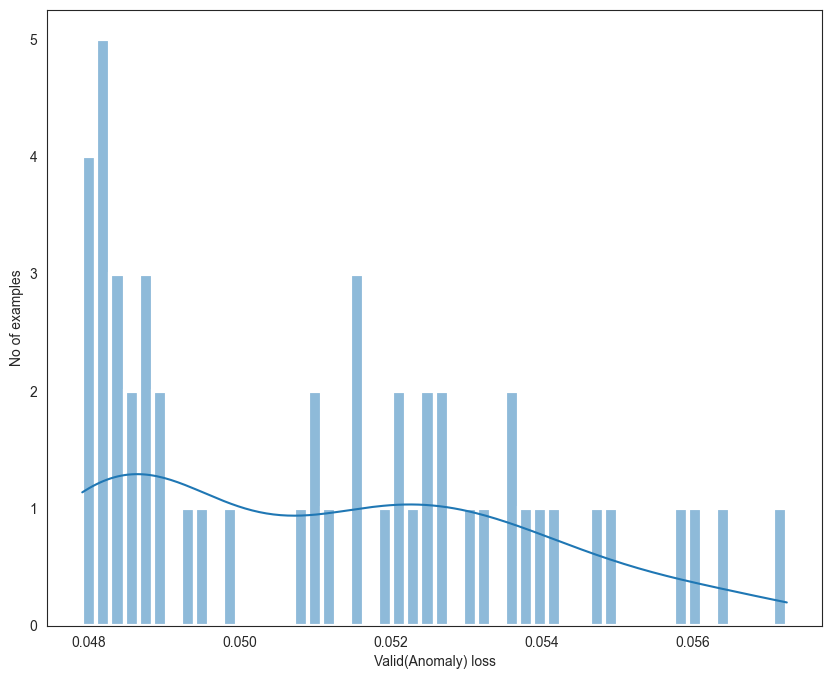

In [94]:
reconstructions = tf.cast(autoencoder.predict(valid_anomaly_ds), tf.float32)
train_loss = tf.sqrt(tf.reduce_mean((valid_anomaly_ds - reconstructions)**2, 1))

fig = plt.figure(figsize=(10, 8))

sns.histplot(train_loss, bins=50, kde=True, linewidth=3)
plt.xlabel("Valid(Anomaly) loss")
plt.ylabel("No of examples")
plt.show()

In [95]:
# 平均＋２×標準偏差をしきい値とします。
threshold_ano = np.mean(train_loss) + np.std(train_loss)*0

print("Mean: ", np.mean(train_loss))
print("Std: ", np.std(train_loss))
print("threshold: ", threshold_ano)

Mean:  0.0511099
Std:  0.002641347
threshold:  0.05110989883542061


### Validation

2/2 [==============================] - 0s 8ms/step


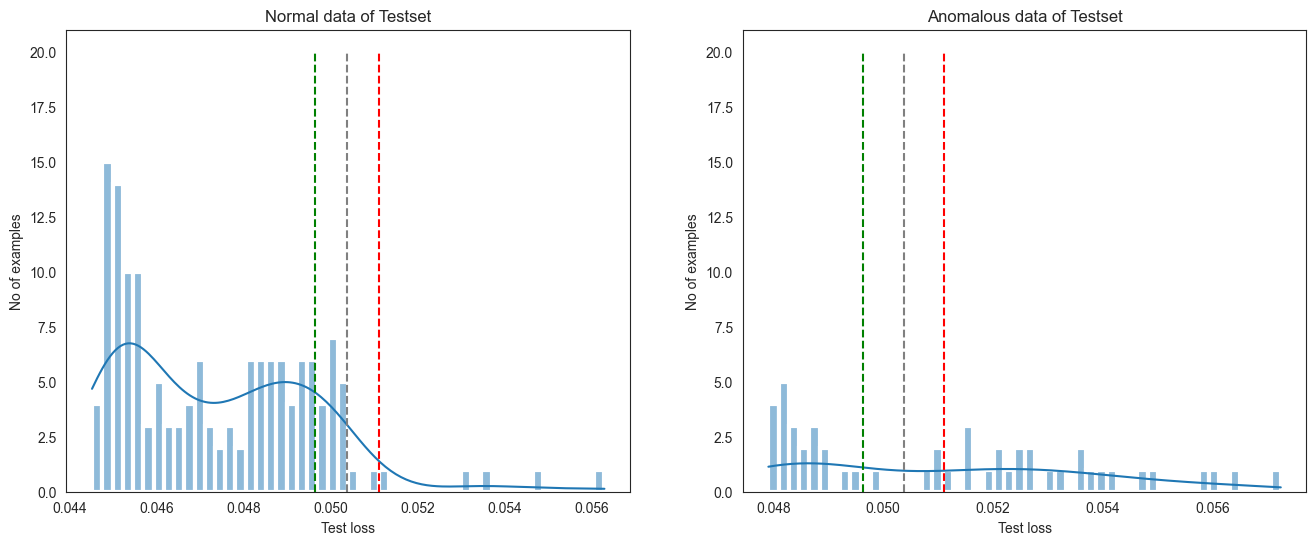

In [96]:
# テストセットの異常なサンプルの再構成エラーを調べます。
# しきい値を変更することで、分類器の精度とリコールを調整できます。

#reconstructions = autoencoder.predict(valid_normal_ds)
#test_loss_no = tf.keras.losses.mae(reconstructions, valid_normal_ds)
#reconstructions = autoencoder.predict(valid_anomaly_ds)
#test_loss_ab = tf.keras.losses.mae(reconstructions, valid_anomaly_ds)

threshold = (threshold_nor + threshold_ano) / 2

reconstructions = tf.cast(autoencoder.predict(valid_normal_ds), tf.float32)
test_loss_no = tf.sqrt(tf.reduce_mean((valid_normal_ds - reconstructions)**2, 1))

reconstructions = tf.cast(autoencoder.predict(valid_anomaly_ds), tf.float32)
test_loss_ab = tf.sqrt(tf.reduce_mean((valid_anomaly_ds - reconstructions)**2, 1))

fig = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
sns.histplot(test_loss_no, bins=50, kde=True, linewidth=3)
plt.vlines(threshold_nor, 0, 20, 'g', 'dashed')
plt.vlines(threshold_ano, 0, 20, 'r', 'dashed')
plt.vlines(threshold, 0, 20, 'gray', 'dashed')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.title("Normal data of Testset")

plt.subplot(1,2,2)
sns.histplot(test_loss_ab, bins=50, kde=True, linewidth=3)
plt.vlines(threshold_nor, 0, 20, 'g', 'dashed')
plt.vlines(threshold_ano, 0, 20, 'r', 'dashed')
plt.vlines(threshold, 0, 20, 'gray', 'dashed')
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.title("Anomalous data of Testset")
plt.show()

In [97]:
#threshold = (threshold_nor + threshold_ano) / 2
threshold = threshold_nor
y_pred_normal = predict_rmse(autoencoder, valid_normal_ds, threshold).numpy()
y_real_normal = np.full(y_pred_normal.shape, False)
print(classification_report(y_real_normal, y_pred_normal))

              precision    recall  f1-score   support

       False       1.00      0.83      0.91       150
        True       0.00      0.00      0.00         0

    accuracy                           0.83       150
   macro avg       0.50      0.42      0.45       150
weighted avg       1.00      0.83      0.91       150



c:\Users\NDO01\Programing\Mission\2410xx_機械稼働音の異常検知\tf-directml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\NDO01\Programing\Mission\2410xx_機械稼働音の異常検知\tf-directml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\NDO01\Programing\Mission\2410xx_機械稼働音の異常検知\tf-directml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

<AxesSubplot:>

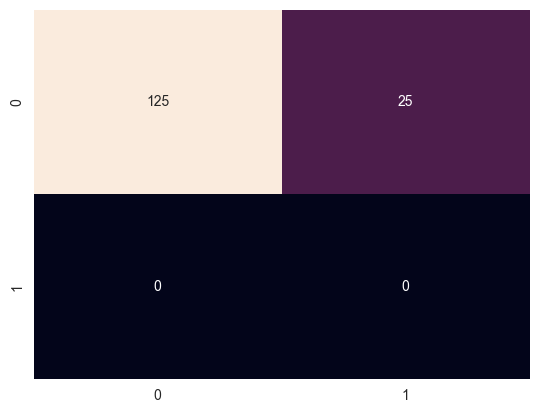

In [98]:
sns.heatmap(confusion_matrix(y_real_normal, y_pred_normal), annot=True, fmt='d', cbar=False)

In [99]:
y_pred_anomaly = predict_rmse(autoencoder, valid_anomaly_ds, threshold)
y_real_anomaly = np.full(y_pred_anomaly.shape, True)
print(classification_report(y_real_anomaly, y_pred_anomaly))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.58      0.73        50

    accuracy                           0.58        50
   macro avg       0.50      0.29      0.37        50
weighted avg       1.00      0.58      0.73        50



c:\Users\NDO01\Programing\Mission\2410xx_機械稼働音の異常検知\tf-directml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\NDO01\Programing\Mission\2410xx_機械稼働音の異常検知\tf-directml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\NDO01\Programing\Mission\2410xx_機械稼働音の異常検知\tf-directml\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

<AxesSubplot:>

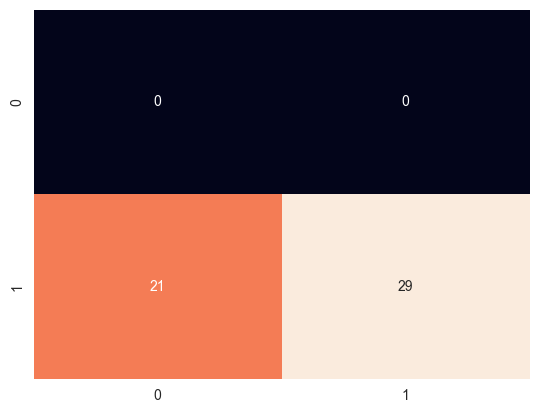

In [100]:
sns.heatmap(confusion_matrix(y_real_anomaly, y_pred_anomaly), annot=True, fmt='d',  cbar=False)

In [101]:
y_pred = np.concatenate([y_pred_normal, y_pred_anomaly])
y_real = np.concatenate([y_real_normal, y_real_anomaly])
print(classification_report(y_real, y_pred))

              precision    recall  f1-score   support

       False       0.86      0.83      0.84       150
        True       0.54      0.58      0.56        50

    accuracy                           0.77       200
   macro avg       0.70      0.71      0.70       200
weighted avg       0.78      0.77      0.77       200



<AxesSubplot:>

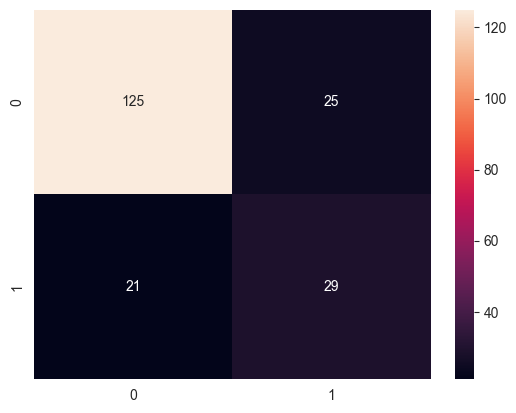

In [102]:
sns.heatmap(confusion_matrix(y_real, y_pred), annot=True, fmt='d')

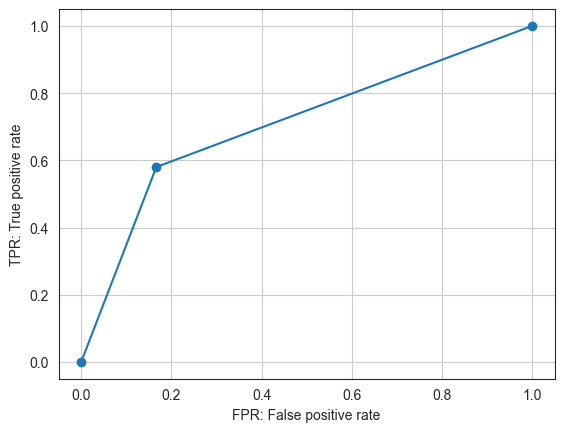

In [103]:
fpr, tpr, th = roc_curve(y_real, y_pred)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [104]:
print(roc_auc_score(y_real, y_pred))

0.7066666666666668


## To Output Submitting CSV

In [105]:
ans = pd.read_csv("../01_input/sample_submit.csv",  header=None)

In [106]:
ans

,0,1
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
195,195,0
196,196,0
197,197,0
198,198,0


In [108]:
# オーディオクリップをfilenamesというリストに抽出します
filenames = glob.glob('../01_input/wav/test/dummy/*.wav')
num_samples = len(filenames)
filenames.sort()
print('Number of total examples:', num_samples)
print('Example file tensor:', filenames[0])

Number of total examples: 200
Example file tensor: ../01_input/wav/test/dummy\000.wav


In [109]:
# Audio Setting
Data_num = valid_normal_audio.shape[0]
Sampling_freq = valid_normal_sampling_rate.numpy()
time_length = Data_num / Sampling_freq

print("Data数：", Data_num)
print("サンプリング周波数[Hz]：", Sampling_freq)
print("時間窓長[sec]:", time_length)
print("分析周波数レンジ[Hz]:", Sampling_freq / 2)

Data数： 160000
サンプリング周波数[Hz]： 16000
時間窓長[sec]: 10.0
分析周波数レンジ[Hz]: 8000.0


In [110]:
AUTOTUNE = tf.data.AUTOTUNE
test_ds = tf.data.Dataset.from_tensor_slices(filenames)

waveform_ds = test_ds.map(
    map_func=get_waveform,
    num_parallel_calls=AUTOTUNE) # トレーニングセット作成

In [111]:
for waveform in waveform_ds.take(1):
  #label = label.numpy().decode('utf-8')
  # spectrogram = get_spectrogram(waveform)
  fft = get_fft(waveform)

#print('Label:', label)
print('Waveform shape:', waveform.shape)
#print('Spectrogram shape:', spectrogram.shape)
print('FFT shape:', fft.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=Sampling_freq))

Waveform shape: (160000,)
FFT shape: (80000,)
Audio playback


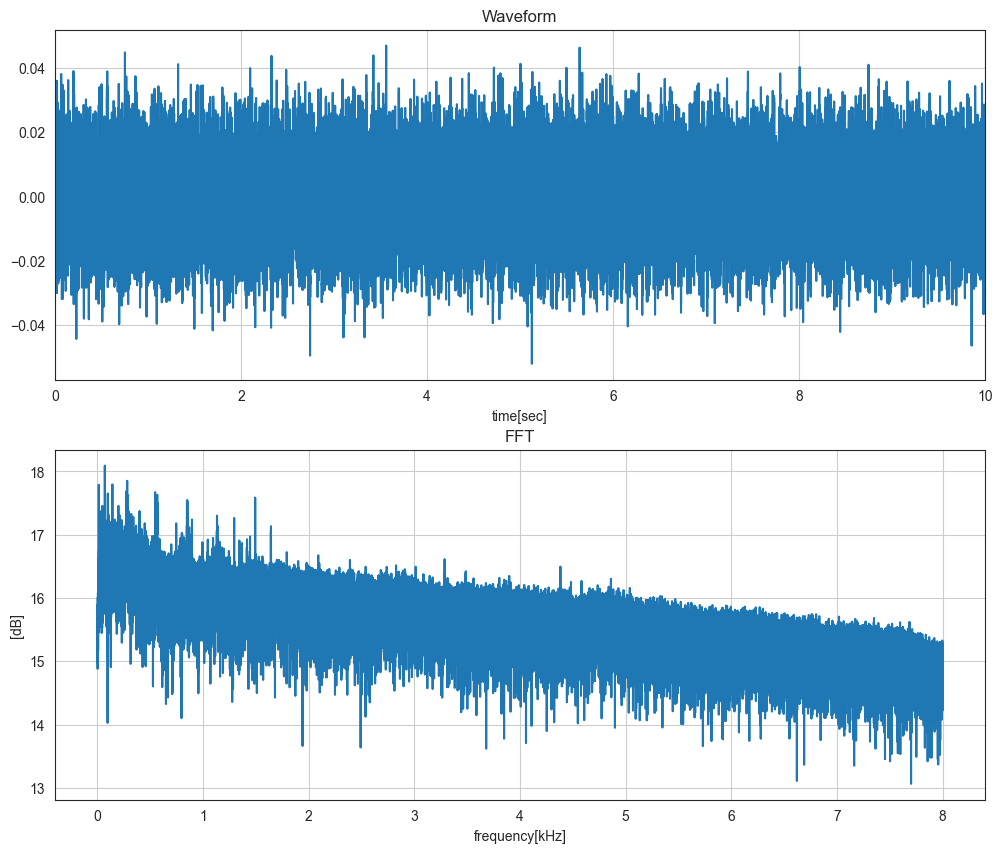

In [112]:
# 時間波形と周波数波形をプロット
timescale = np.arange(Data_num) #len(waveform)
timescale = timescale/Sampling_freq

freq = np.arange(Data_num//2) * Sampling_freq / Data_num

fig, axes = plt.subplots(2, figsize=(12, 10))

axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, Data_num/Sampling_freq]) # [0, Data_num]
axes[0].set_xlabel("time[sec]")
axes[0].grid()

axes[1].plot(freq/1000, fft)
axes[1].set_title('FFT')
axes[1].set_xlabel("frequency[kHz]")
axes[1].set_ylabel("[dB]")
axes[1].grid()
plt.show()

In [113]:
# 各データリストをFFTへ変換
test_ds = preprocess_dataset(filenames)
test_ds = list(test_ds)

In [114]:
# FFTの値を[0,1]の範囲へnormarization
min_val = tf.reduce_min(test_ds) # trainデータセットの最小値取得
max_val = tf.reduce_max(test_ds) # trainデータセットの最大値取得

test_ds = (test_ds - min_val) / (max_val - min_val) # [0,1]へ正規化
test_ds = tf.cast(test_ds, tf.float32) # 型の変換

In [115]:
input_shape = valid_anomaly_ds.shape
input_shape = input_shape[1]
print('Input shape:', input_shape)

Input shape: 80000


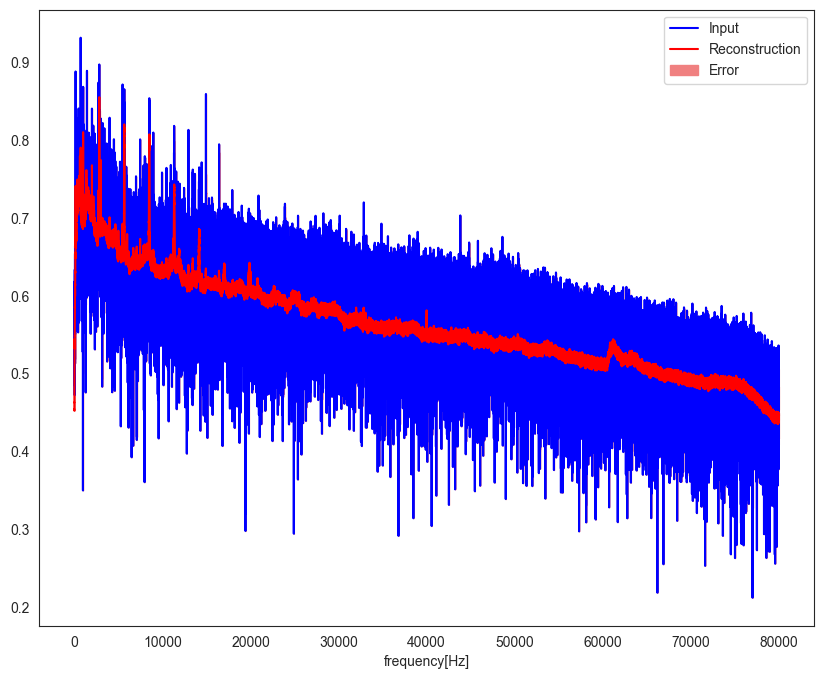

In [116]:
# 試験サンプル

decoded_data = autoencoder(test_ds).numpy()

fig = plt.figure(figsize=(10, 8))

plt.plot(test_ds[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(input_shape), decoded_data[0], test_ds[0], color='lightcoral') #
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.xlabel('frequency[Hz]')
plt.show()

7/7 [==============================] - 0s 10ms/step


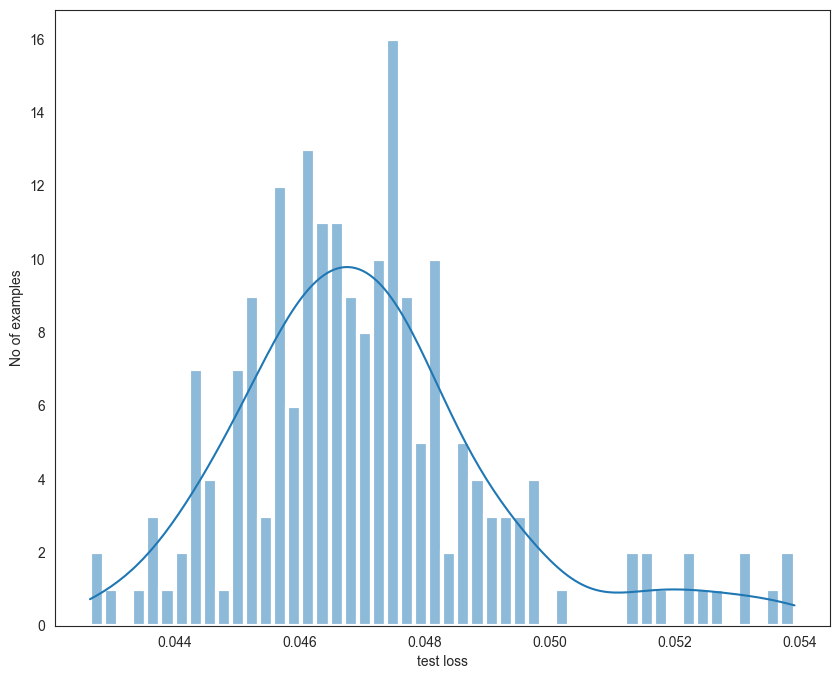

In [118]:
reconstructions = tf.cast(autoencoder.predict(test_ds), tf.float32)
loss = tf.sqrt(tf.reduce_mean((test_ds - reconstructions)**2, 1))

fig = plt.figure(figsize=(10, 8))

sns.histplot(loss, bins=50, kde=True, linewidth=3)
plt.xlabel("test loss")
plt.ylabel("No of examples")
plt.show()

In [120]:
# 平均＋２×標準偏差をしきい値とします。
threshold = np.mean(loss) + np.std(loss)*2
print("Mean: ", np.mean(loss))
print("Std: ", np.std(loss))
print("Threshold: ", threshold)

Mean:  0.04707859
Std:  0.002108099
Threshold:  0.05129478871822357


In [121]:
y_pred = predict_rmse(autoencoder, test_ds, threshold).numpy()

In [122]:
ans[1] = y_pred * 1
ans

,0,1
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
195,195,0
196,196,0
197,197,0
198,198,0


In [126]:
ans.to_csv(path_or_buf = "../05_submittion/submission_.csv", index=False, header=None)